In [1]:
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

In [5]:
# load the first rows of the data
df = pd.read_csv("../data/BANES_v3_oneweek.csv", parse_dates=['time'], nrows=10)
columns = df.drop(['energy', 'location', 'time'], axis=1).columns

In [6]:
model: xgb.XGBRegressor = pickle.load(open("../models/model_featureimportance.pkl", "rb"))
feature_importance = pd.Series(model.feature_importances_, index=columns)

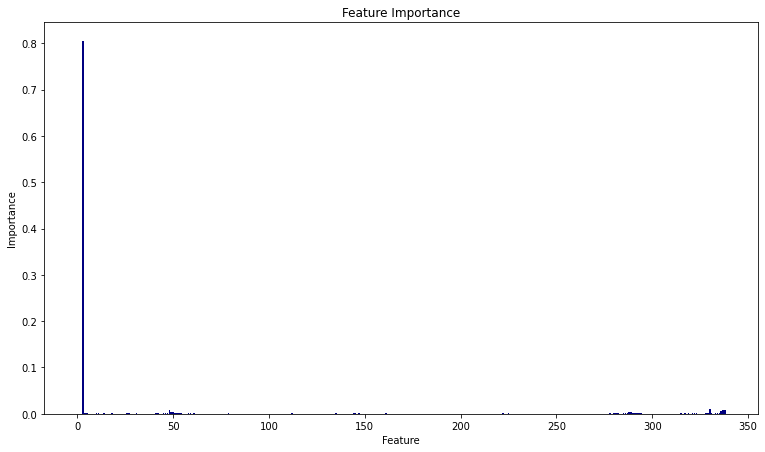

In [9]:
plt.figure(figsize=(12.8, 7.2))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_, color="navy")
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

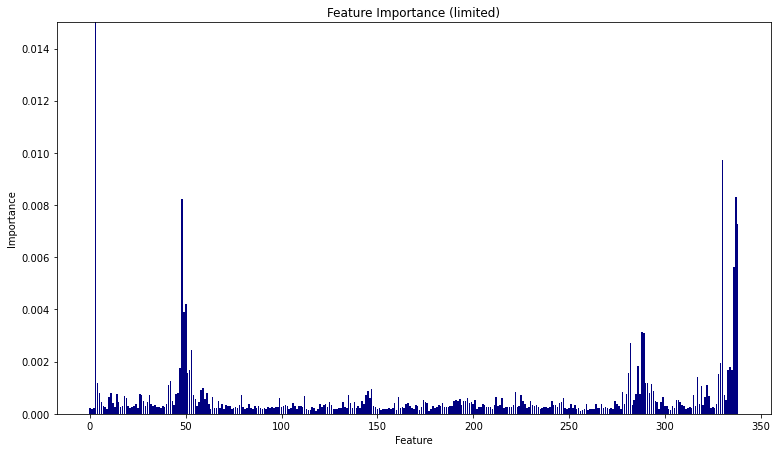

In [12]:
plt.figure(figsize=(12.8, 7.2))

plt.bar(range(len(model.feature_importances_)), model.feature_importances_, color="navy")
# on the top of the bar plot, add the feature names but only for the 20 largest features
plt.title('Feature Importance (limited)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.ylim([0, 0.015])
plt.show()

Market prices

In [16]:
df = pd.read_csv("../data/BANES_v2.csv", parse_dates=['time'])
df.head()

,location,time,energy,AirTemp,RelativeHumidity,Dni
0,## OLD Paulton Library Electricity Supply 1,2008-06-14 00:30:00+00:00,0.08,9.1,0.829,0.0
1,## OLD Paulton Library Electricity Supply 1,2008-06-14 01:00:00+00:00,0.07,8.9,0.836,0.0
2,## OLD Paulton Library Electricity Supply 1,2008-06-14 01:30:00+00:00,0.08,8.7,0.844,0.0
3,## OLD Paulton Library Electricity Supply 1,2008-06-14 02:00:00+00:00,0.07,8.5,0.852,0.0
4,## OLD Paulton Library Electricity Supply 1,2008-06-14 02:30:00+00:00,0.08,8.3,0.860,0.0


In [18]:
df = df.groupby(['time']).mean().reset_index()
df.head()

,time,energy,AirTemp,RelativeHumidity,Dni
0,2007-01-01 00:30:00+00:00,25.50,8.0,0.814,0.0
1,2007-01-01 01:00:00+00:00,25.75,7.7,0.833,0.0
2,2007-01-01 01:30:00+00:00,26.15,7.3,0.852,0.0
3,2007-01-01 02:00:00+00:00,27.55,7.0,0.872,0.0
4,2007-01-01 02:30:00+00:00,27.95,6.6,0.892,0.0


In [21]:
from datetime import timedelta, datetime
import pytz

def tarifa_bihoraria_diaria_ponta(time) -> bool:
    return time.hour >= 8 and time.hour < 22

def tarifa_bihoraria_semanal_ponta(time: datetime) -> bool:
    time = time.astimezone(pytz.timezone("Europe/Lisbon"))

    hour = time.hour
    # if it is daylight savings time
    if time.tz.dst != timedelta(0):
        if time.weekday() == 5:
            # it is saturday
            if hour < 9 or (hour >= 14 and hour < 20) or (hour >= 22):
                tarifa = False
            else:
                tarifa = True
        elif time.weekday() == 6:
            # it is sunday
            tarifa = False
        else:
            if hour < 7:
                tarifa = False
            else:
                tarifa = True
    else:
        if time.weekday() == 5:
            # it is saturday
            if (
                time.to_pydatetime()
                < datetime(
                    time.year,
                    time.month,
                    time.day,
                    9,
                    30,
                    0,
                    tzinfo=pytz.timezone("Europe/Lisbon"),
                )
                or (
                    time.to_pydatetime()
                    >= datetime(
                        time.year,
                        time.month,
                        time.day,
                        13,
                        0,
                        0,
                        tzinfo=pytz.timezone("Europe/Lisbon"),
                    )
                    and time.to_pydatetime()
                    < datetime(
                        time.year,
                        time.month,
                        time.day,
                        18,
                        30,
                        0,
                        tzinfo=pytz.timezone("Europe/Lisbon"),
                    )
                )
                or (
                    time.to_pydatetime()
                    >= datetime(
                        time.year,
                        time.month,
                        time.day,
                        22,
                        0,
                        0,
                        tzinfo=pytz.timezone("Europe/Lisbon"),
                    )
                )
            ):
                tarifa = False
            else:
                tarifa = True
        elif time.weekday() == 6:
            # it is sunday
            tarifa = False
        else:
            if hour < 7:
                tarifa = False
            else:
                tarifa = True
    return tarifa


In [22]:
TARIFA_SIMPLES = 0.1583
TARIFA_PONTA = 0.1917
TARIFA_FORA_PONTA = 0.1044

def no_production(line: pd.array) -> pd.array:
    """No production scenario. All energy consumed comes from the grid."""
    # add prices
    tarifa_diario = TARIFA_PONTA if tarifa_bihoraria_diaria_ponta(line["time"]) else TARIFA_FORA_PONTA
    line["price_bihorario_diario"] = tarifa_diario * line["energy"]
    tarifa_semanal = TARIFA_PONTA if tarifa_bihoraria_semanal_ponta(line["time"]) else TARIFA_FORA_PONTA
    line["price_bihorario_semanal"] = tarifa_semanal * line["energy"]
    line["price_simples"] = TARIFA_SIMPLES * line["energy"]
    return line

no_prod = df[["time", "energy"]]
no_prod["time"] = pd.to_datetime(no_prod["time"])
no_prod = no_prod.apply(no_production, axis=1)
no_prod.sum().apply(lambda x: f"{x:.4f}")

C:\Users\migue\AppData\Local\Temp/ipykernel_120968/3296489012.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_prod["time"] = pd.to_datetime(no_prod["time"])
C:\Users\migue\AppData\Local\Temp/ipykernel_120968/3296489012.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  no_prod.sum().apply(lambda x: f"{x:.4f}")


energy                     1741886.1067
price_bihorario_diario      285857.4185
price_bihorario_semanal     283567.7304
price_simples               275740.5707
dtype: object

In [23]:
no_prod.head()

,time,energy,price_bihorario_diario,price_bihorario_semanal,price_simples
0,2007-01-01 00:30:00+00:00,25.50,2.66220,2.66220,4.036650
1,2007-01-01 01:00:00+00:00,25.75,2.68830,2.68830,4.076225
2,2007-01-01 01:30:00+00:00,26.15,2.73006,2.73006,4.139545
3,2007-01-01 02:00:00+00:00,27.55,2.87622,2.87622,4.361165
4,2007-01-01 02:30:00+00:00,27.95,2.91798,2.91798,4.424485


In [39]:
cumsum = no_prod.cumsum()
cumsum.head()

,time,energy,price_bihorario_diario,price_bihorario_semanal,price_simples
0,2007-01-01 00:30:00+00:00,25.50,2.66220,2.66220,4.036650
1,2044-01-01 01:30:00+00:00,51.25,5.35050,5.35050,8.112875
2,2080-12-31 03:00:00+00:00,77.40,8.08056,8.08056,12.252420
3,2118-01-01 05:00:00+00:00,104.95,10.95678,10.95678,16.613585
4,2155-01-01 07:30:00+00:00,132.90,13.87476,13.87476,21.038070


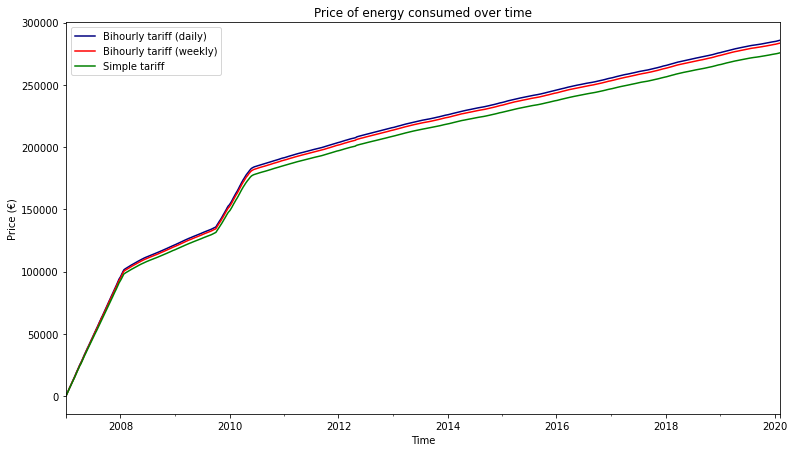

In [44]:
cumsum["time"] = no_prod["time"]
ax = cumsum.plot(x="time", y="price_bihorario_diario", c="navy", figsize=(12.8, 7.2))
cumsum.plot(x="time", y="price_bihorario_semanal", c="red", ax=ax)
cumsum.plot(x="time", y="price_simples", c="green", ax=ax)
plt.legend(["Bihourly tariff (daily)", "Bihourly tariff (weekly)", "Simple tariff"])
plt.title("Price of energy consumed over time")
plt.xlabel("Time")
plt.ylabel("Price (€)")
plt.show()

In [47]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
no_prod.describe()

,energy,price_bihorario_diario,price_bihorario_semanal,price_simples
count,229728.0000,229728.0000,229728.0000,229728.0000
mean,7.5824,1.2443,1.2344,1.2003
std,10.1052,1.8411,1.8388,1.5997
min,0.6400,0.0668,0.0691,0.1013
25%,2.5148,0.3369,0.3044,0.3981
50%,3.8570,0.5800,0.6037,0.6106
75%,6.7914,1.2634,1.2706,1.0751
max,60.1500,11.5308,11.5308,9.5217


In [48]:
no_prod.sum().apply(lambda x: f"{x:.4f}")

C:\Users\migue\AppData\Local\Temp/ipykernel_120968/2631640189.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  no_prod.sum().apply(lambda x: f"{x:.4f}")


energy                     1741886.1067
price_bihorario_diario      285857.4185
price_bihorario_semanal     283567.7304
price_simples               275740.5707
dtype: object